In [87]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from processing_func import check_coords, calc_N2_kappa, calc_hab, arctic_calchab, calc_N2_kappa_sorted, calc_sic
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [88]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc"
nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc"
HM_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/HM_ds.nc"
NN_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
NN_ds = xr.open_dataset(NN_nc)

In [89]:
arctic_ds = arctic_ds.reset_coords(["latitude", "longitude", "time"])
mosaic_ds = mosaic_ds.reset_coords(["latitude", "longitude", "time"])
alberto_ds = alberto_ds.reset_coords(["latitude", "longitude", "time"])
nice_ds = nice_ds.reset_coords(["latitude", "longitude", "time"])
HM_ds = HM_ds.reset_coords(["latitude", "longitude", "time"])

In [90]:
# Bathymetry dataset
GEBCO_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc"
bathy_ds = xr.open_dataset(GEBCO_ds)

In [91]:
# Sea ice fraction data
SI_HadISST = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/SI-area/HadISST_ice.nc"
Hadi_SI = xr.open_dataset(SI_HadISST)

## Add all features and combine all datasets into one dataframe
The features and the plots are explained below

In [92]:
nice_kappa = calc_N2_kappa_sorted(nice_ds)
mosaic_kappa = calc_N2_kappa_sorted(mosaic_ds)
HM_kappa = calc_N2_kappa_sorted(HM_ds)
arctic_kappa = calc_N2_kappa_sorted(arctic_ds)
alberto_kappa = calc_N2_kappa_sorted(alberto_ds)

#nice_kappa = calc_sic(nice_kappa, Hadi_SI)
#alberto_kappa = calc_sic(alberto_kappa, Hadi_SI)
#HM_kappa = calc_sic(HM_kappa, Hadi_SI)
#arctic_kappa = calc_sic(arctic_kappa, Hadi_SI)
#alberto_kappa = calc_sic(alberto_kappa, Hadi_SI)

arctic_final = arctic_calchab(arctic_kappa, bathy_ds)
nice_final = calc_hab(nice_kappa, bathy_ds)
mosaic_final = calc_hab(mosaic_kappa, bathy_ds)
HM_final = calc_hab(HM_kappa, bathy_ds)
alberto_final = calc_hab(alberto_kappa, bathy_ds)

871it [00:07, 122.03it/s]
100%|██████████| 351/351 [00:00<00:00, 504.28it/s]


In [93]:
# add variables of the cruise name
arctic_final["cruise"] = "ArcticMix"
nice_final["cruise"] = "NICE"
mosaic_final["cruise"] = "Mosaic"
alberto_final["cruise"] = "ASBO"
HM_final["cruise"] = "HM"

## Select variables from datasets

In [94]:
def select_variables(data, variables):
    """
    Select specific variables from the given dataset and reduce dimensions and coordinates to depth and profile.
    Args:
        data (xarray.Dataset): Input dataset containing variables.
        variables (list): List of variable names to select.
    Returns:
        xarray.Dataset: Dataset with selected variables and reduced dimensions/coordinates.
    """
    # Select the desired variables from the dataset
    selected_data = data[variables]
    # Reduce dimensions and coordinates to depth and profile
    selected_data = selected_data.squeeze().reset_coords(drop=True)
    return selected_data

In [104]:
mosaic_final["log_eps"] = mosaic_final["eps"]

In [105]:
# selected_columns = ["depth", "profile", "latitude", "longitude", "P", "S", "T", "Tu", "kappa", "log_N2", "log_kappa", "log_eps", "dTdz", "dSdz", "eps", "cruise", "hab", "Tu_label", "time"]
selected_columns = ["depth", "profile", "latitude", "longitude", "cruise", "S", "T", "log_eps", "log_N2", "dTdz", "dSdz", "hab", "Tu", "Tu_label", "time"]

arctic_f = select_variables(arctic_final, selected_columns)
alberto_f = select_variables(alberto_final, selected_columns)
mosaic_f = select_variables(mosaic_final, selected_columns)
HM_f = select_variables(HM_final, selected_columns)
nice_f = select_variables(nice_final, selected_columns)

In [106]:
arctic_df = arctic_f.to_dataframe().reset_index()
HM_df = HM_f.to_dataframe().reset_index()
mosaic_df = mosaic_f.to_dataframe().reset_index()
alberto_df = alberto_f.to_dataframe().reset_index()
nice_df = nice_f.to_dataframe().reset_index()

In [107]:
combined_df = pd.concat([arctic_df, HM_df, mosaic_df, alberto_df, nice_df])
combined_nona = combined_df.copy()
combined_nona = combined_nona.dropna()
len(combined_nona)

589285

2101764 without
1307594 with P, S, T
1287803 with P, S, T, eps ## baseline
876875 with P, S, T, eps, logN2
876875 with P, S, T, eps, logN2, dTdz, dS,dz # all still aboard
867841 with P, S, T, eps, logN2, dTdz, dS,dz, hab
867841 with P, S, T, eps, logN2, dTdz, dS,dz, hab, Tu & Tu_label
862023 with P, S, T, eps, logN2, dTdz, dS,dz, hab, Tu & Tu_label and time

In [108]:
combined_nona.cruise.unique()

array(['ArcticMix', 'HM', 'Mosaic', 'ASBO', 'NICE'], dtype=object)

In [109]:
combined_nona.to_pickle('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/0106all.pkl')

## Visualise this non na dataset

In [110]:
full_df = pd.read_pickle('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/0106all.pkl')

/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


AttributeError: 'Line2D' object has no attribute 'get_sizes'

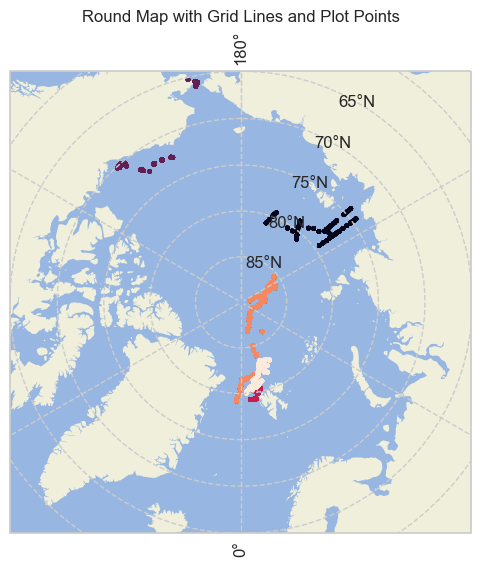

In [111]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.legend_handler import HandlerPathCollection

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())

# Add land, ocean, and borders
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))

# Convert non-numeric cruise values to category codes
full_df["cruise_codes"] = full_df["cruise"].astype("category").cat.codes

scatter = ax.scatter(full_df["longitude"], full_df["latitude"], c=full_df["cruise_codes"],
                     transform=ccrs.PlateCarree(), s=5)

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_bottom = True
gl.ylabels_left = True

ax.set_title("Round Map with Grid Lines and Plot Points")

# Create a custom legend
unique_cruises = full_df["cruise"].unique()
legend_handles = [plt.Line2D([], [], linestyle='None', marker='o', markersize=5, color='k') for _ in unique_cruises]
legend_labels = unique_cruises

ax.legend(legend_handles, legend_labels, handler_map={plt.Line2D: HandlerPathCollection()}, loc="center left")

plt.show()


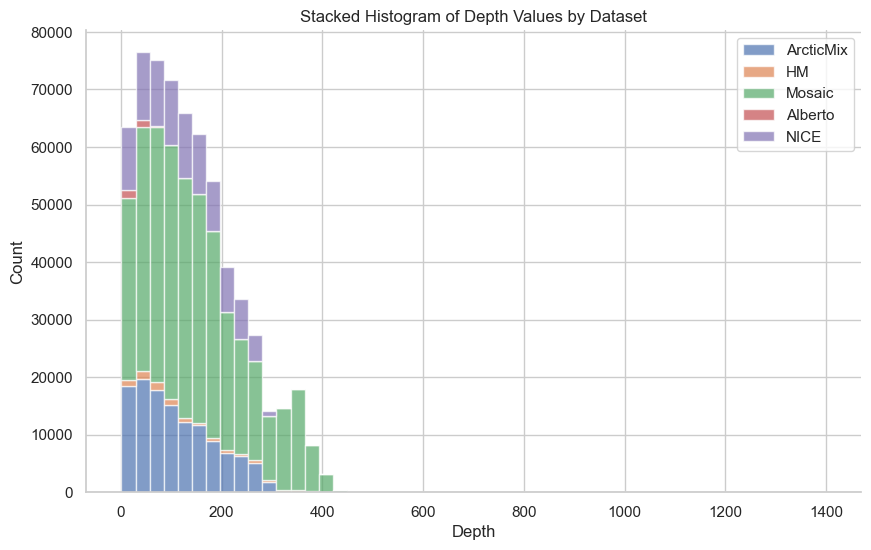

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up Seaborn style
sns.set(style='whitegrid')

# Define the depth values and cruise labels
depth_values = [full_df.loc[full_df['cruise'] == cruise, 'depth'] for cruise in full_df['cruise'].unique()]
labels = full_df['cruise'].unique()

# Plot a stacked histogram with labeled bars
plt.figure(figsize=(10, 6))
plt.hist(depth_values, bins=50, stacked=True, label=labels, alpha=0.7)

plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Stacked Histogram of Depth Values by Dataset')
plt.legend()

# Remove the right and top spines
sns.despine()

# Display the plot
plt.show()

## Visualise all the points

In [ ]:
total_profiles = len(HM_ds["longitude"]) + len(nice_ds["longitude"]) + len(mosaic_ds["longitude"]) + len(alberto_ds["longitude"]) + len(arctic_ds["longitude"])
print("total amount of profiles is: ", total_profiles)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# Add land, ocean, and borders
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))

ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label="HM")
ax.scatter(nice_ds["longitude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label="Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label="Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label="Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label="ArcticMix")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.bottom_labels = True  # Show x-axis labels at the bottom
gl.left_labels = True  # Show y-axis labels on the left

ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
ax.set_title("Round Map with Grid Lines and Plot Points")
ax.legend(loc="center left")
plt.show()

In [ ]:
total_profiles = len(HM_ds["longitude"]) + len(nice_ds["longitude"]) + len(mosaic_ds["longitude"]) + len(alberto_ds["longitude"]) + len(arctic_ds["longitude"])
print("total amount of profiles is: ", total_profiles)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longitude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()

In [ ]:
# Select the depth variable from each dataset
depth1 = arctic_ds['depth'].sel()
depth2 = alberto_ds['depth'].sel()
depth3 = nice_ds['depth'].sel()
depth4 = mosaic_ds['depth'].sel()
depth5 = HM_ds['depth'].sel()

# Concatenate the depth values into a single array
depth_values = np.concatenate([depth1.values, depth2.values, depth3.values, depth4.values, depth5.values])

# Plot a histogram of the combined depth values
plt.hist(depth_values, bins=50)
plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Histogram of Depth Values')
plt.show()

In [ ]:
import seaborn as sns

# Select the depth variable from each dataset
depth1 = arctic_ds['depth'].sel()
depth2 = alberto_ds['depth'].sel()
depth3 = nice_ds['depth'].sel()
depth4 = mosaic_ds['depth'].sel()
depth5 = HM_ds['depth'].sel()

# Combine the depth values into a single array
depth_values = np.concatenate([depth1.values, depth2.values, depth3.values, depth4.values, depth5.values])

# Create a list of labels for each dataset
labels = ['Arctic', 'Alberto', 'Nice', 'Mosaic', 'HM']

# Set up Seaborn style
sns.set(style='whitegrid')

# Plot a stacked histogram with labeled bars
plt.figure(figsize=(10, 6))
plt.hist([depth1, depth2, depth3, depth4, depth5], bins=50, stacked=True, label=labels, alpha=0.7)

plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Stacked Histogram of Depth Values by Dataset')
plt.legend()

# Remove the right and top spines
sns.despine()

# Display the plot
plt.show()

# From now on, pretend like nice_ds is the combined_ds


## Calculate features like in Mashayek et al. (2021)

In [ ]:
from scipy.interpolate import interp1d
from matplotlib import colors

In [ ]:
nice_kappa = calc_N2_kappa(nice_ds)
nice_kappa.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e-1),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
nice_kappa.eps.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-10, vmax = 1e-4),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
HM_kappa = HM_ds.squeeze()
HM_kappa = HM_kappa.transpose('depth', 'profile')
HM = calc_N2_kappa(HM_kappa)
HM.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e-4),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
HM.eps.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-11, vmax = 1e-7),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
alberto_kappa = calc_N2_kappa(alberto_ds)
alberto_kappa.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-5, vmax = 1e1),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
alberto_kappa.eps.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e1),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
arctic_ds = arctic_ds.squeeze()
arctic = calc_N2_kappa_func(arctic_ds)
arctic.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e-1),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
mosaic = calc_N2_kappa(mosaic_ds)
mosaic.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e4, vmax = 1e7),cmap='viridis',figsize=(20,5))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
mosaic.eps.plot(y = 'depth', cmap='viridis',figsize=(20,5))


## Hab

In [ ]:
from tqdm import tqdm

In [ ]:
def calc_hab_func(data):
    bathy_interp = bathy_ds.interp_like(data, method='nearest')
    n_depths = data.profile.shape[0]
    depth = np.zeros(n_depths)

    for i in tqdm(range(n_depths)):
        microlon = data.longitude[i].values.flatten()
        microlat = data.latitude[i].values.flatten()
        depth[i] = bathy_interp.elevation.sel(lon=microlon,lat=microlat, method='nearest')
    data['bathymetry'] = data.profile.copy(data=depth)
    
    data["hab"] = data.bathymetry + abs(data.depth)
    data["hab"] = data["hab"].where(data["hab"] <= 0, 0)  # Set positive values to zero
    return data

In [ ]:
alberto_hab = calc_hab_func(alberto_ds)
alberto_hab.bathymetry.plot()

In [ ]:
mosaic_hab = calc_hab_func(mosaic_ds)
mosaic_hab.bathymetry.plot()

In [ ]:
nice_hab = calc_hab_func(nice_ds)
nice_hab.bathymetry.plot()

In [ ]:
HM_hab = calc_hab_func(HM_ds)
HM_hab.bathymetry.plot()

In [ ]:
def arctic_calchab_func(data):
    # group data by the 'profile' dimension
    profile_groups = data.groupby('profile')

    bathy_interp = bathy_ds.interp_like(data, method='nearest')
    n_profiles = len(data.depth)

    profile = np.zeros(len(profile_groups))

    # loop over each group
    for i, (_, profile_data) in tqdm(enumerate(profile_groups)):
        microlat = profile_data.latitude.values.flatten()[0]
        microlon = profile_data.longitude.values.flatten()[0]
        profile[i] = bathy_interp.elevation.sel(lon=microlon, lat=microlat, method='nearest').values

    # Create a DataArray for bathymetry with the 'profile' dimension
    profile_arr = xr.DataArray(profile, coords=[range(len(profile_groups))], dims=['profile'])
    data['bathymetry'] = profile_arr
    data["hab"] = data.bathymetry + abs(data.depth)
    data["hab"] = data["hab"].where(data["hab"] <= 0, 0)  # Set positive values to zero
    return data

In [ ]:
arctic_hab = arctic_calchab_func(arctic_ds)
arctic_hab.bathymetry.plot()